In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from matplotlib.animation import FuncAnimation
import random


pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
plt.style.use('seaborn-whitegrid')


def randomint(start, end):
    return np.random.randint(start, end)
def PercentChance(percent):
    return random.uniform(0,100) < percent

def Sort2(sub_li):
    return(sorted(sub_li, key = lambda x: str(x)))  

C:\Users\Aidan\AppData\Local\Temp\ipykernel_14656\3219427498.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [12]:
class virus:
    VirusDuration = 200
    InfectionBounds = 5
    DeathChance = 0.05 

class Boundary:
    X = 200
    Y = 200
    
    def bounds_check(person):
        pass
        
sim_length = 200
initial_infectors = 1
num_people = 300

In [13]:

class person_obj:
    
    def __init__(self, x, y, vx, vy, status):
        
        # Attributes of each person
        
        self.x = x                  # Cartisan location
        self.y = y
        self.vx = vx                # Velocities
        self.vy = vy
        self.status = status        # 
        self.InfectedTime = 0       # Counter records number of epochs since infection
        self.ImmunityWear = 4       # Percentege for status to go 'Recovered' to 'Susceptible'
        
    # Each peron has a current string status of the following:
    #  "Susceptible" has the ability to become infected. 
    #  "Infected" can infect others if in close enough range to susceptible.
    #  "Recovered" is immune to becoming infected.
    #  "Dead" will no longer interact with anything.
           
    def BoundsCheck(self, attr):
    # Restricts the movements of the person.
    # In this case its a rectangle with specified width as X in the boundary class
    # 
    # Probaly should be in the boundary class where shape is specified and conditions below       
        if attr == 'x':                  
            if self.x > Boundary.X:
                self.x = Boundary.X
                self.vx = -self.vx
            if self.x < 0:
                self.x = 0
                self.vx = -self.vx
            return
        if attr == 'y':
            if self.y > Boundary.Y:
                self.y = Boundary.Y
                self.vy = -self.vy
            if self.y < 0:
                self.y = 0
                self.vy = -self.vy
            return

    def __setattr__(self, attr, value):
        self.__dict__[attr] = value
        if attr in ['x', 'y']:
            self.BoundsCheck(attr)
            
    def location(self):
        return np.array([self.x, self.y])
    def velocity(self):
        return np.array([self.vx, self.vy])
    def MovePerson(self):
        if self.status != 'Dead':
            Newlocation = self.location() + self.velocity()
            self.x = Newlocation[0]
            self.y = Newlocation[1]      

    def ModifyStatus(self):
        if self.status == 'Infected' and PercentChance(virus.DeathChance):
            self.status = 'Dead'
        if self.status == 'Recovered' and PercentChance(self.ImmunityWear):
            self.status = 'Susceptible'
            self.InfectedTime = 0

        
        
        

In [14]:
def main(num_people, InitialInfector, sim_length):
    
    def create_people(num_people, initial_infectors):
        People = []
        for i in range(num_people):
            if i < initial_infectors:
                status = 'Infected'     
            else:
                status = 'Susceptible'
            # Generates a from the person class with random attributes    
            People.append(person_obj(randomint(0, Boundary.X), randomint(0, Boundary.Y), randomint(-2, 2) 
                                     ,randomint(-1, 1), status))
        People = Sort2(People)
        return People
    # list created with a number of infected people
    People = create_people(num_people, initial_infectors)
    
    produceed_data = []
    for index, person in enumerate(People):
        InitialData = [person, 0, person.x, person.y, person.vx, person.vy, person.status]
        produceed_data.append(InitialData)
        
    
    
    for epoch in range(1, sim_length+1):
        Infected = []
        EpochMembers = []

        for person in People:

            person_obj.MovePerson(person)
            person_obj.ModifyStatus(person)
            data = [person, epoch, person.x, person.y, person.vx, person.vy, person.status]
            produceed_data.append(data)
            EpochMembers.append(data)
            
            if person.status == 'Infected':
                Infected.append(person)
            
        
        Temp = np.array(EpochMembers)
        X = Temp[:, 2]
        Y = Temp[:, 3]
        XY = np.column_stack((X,Y)).astype(int)

        dist_sq = np.sqrt(np.sum((XY[:, np.newaxis, :] - XY[np.newaxis, :, :])**2, axis=-1)).round(2)
        

        for i in Infected:
            
            Current = dist_sq[slice(None), People.index(i)]
            
            Indanger = np.where((Current < virus.InfectionBounds) & (Current != 0))[0]
            
            i.InfectedTime += 1          
            PeopleArr = np.array(People) # Convert to numpy array to use fancy indexing
            
            for j in PeopleArr[Indanger]:
                if j.status == 'Susceptible':
                    j.status = 'Infected'
            if i.InfectedTime > virus.VirusDuration:
                i.status = 'Recovered'

    return produceed_data, dist_sq, People


In [15]:
produced_data, dist_sq, people = main(num_people, initial_infectors, sim_length)

In [16]:
simulation = pd.DataFrame(produced_data, columns=['Person', 'Epoch', 'x', 'y', 'vx', 'vy','Status'])
simulation = simulation.sort_values(by=['Person', 'Epoch'], key=lambda col: col.astype(str))

In [17]:
def extract_data(simulation, sim_length):
    
    # Convert status to color
    def convert_color(ele):
        if ele == 'Susceptible':
            return 'b'
        elif ele == 'Infected':
            return 'r'
        elif ele == 'Recovered':
            return 'g'
        elif ele == 'Dead':
            return 'k'

    # Generate animation from dataframe
    cord_history = []
    color_history = []

    for i in range(sim_length):
        grid_x_locations = simulation['x'][simulation['Epoch'] == i].values
        grid_y_locations = simulation['y'][simulation['Epoch'] == i].values
        grid_status = simulation['Status'][simulation['Epoch'] == i].values

        grid_locations = np.column_stack((grid_x_locations, grid_y_locations)).astype(int)

        grid_status = [convert_color(x) for x in grid_status]

        cord_history.append(grid_locations)
        color_history.append(grid_status)
    return color_history, cord_history


In [18]:
color_history, cord_history = extract_data(simulation, sim_length)


<IPython.core.display.Javascript object>


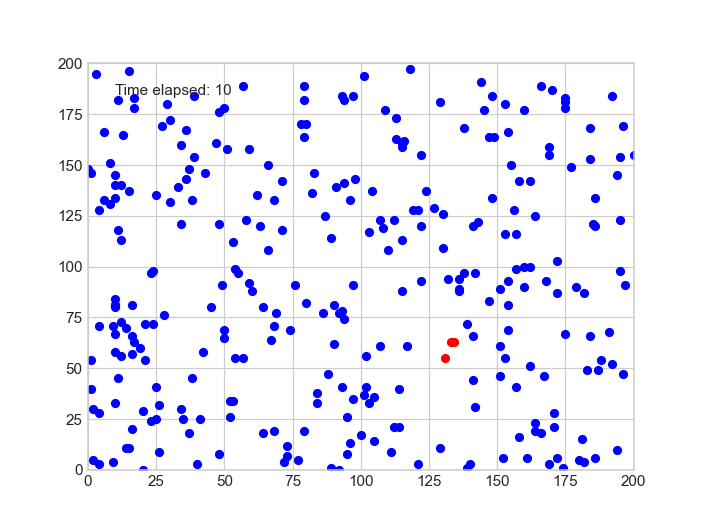

In [19]:
%matplotlib notebook
fig, ax = plt.subplots()

# ax.set(xlim=(0, 100), ylim=(0, 100))
ax.set_xlim(0, Boundary.X)
ax.set_ylim(0, Boundary.Y)

time_text = ax.text(0.05, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)
time_text.set_text('Time elapsed: 0')

# ax.legend(handles=legen_elements)
graph_dots = []

for k in range(num_people):
    graph_dot, = ax.plot(cord_history[0][k][0], cord_history[0][k][1], 'o', color=color_history[0][k], markersize=5)
    graph_dots.append(graph_dot)
    
def animation_frame(frame, graph_dots, num_people, cord_history, color_history):
    for k in range(num_people):
        if graph_dots[k] != cord_history[frame][k][0]:
            graph_dots[k].set_xdata(cord_history[frame][k][0])
        if graph_dots[k] != cord_history[frame][k][1]:
            graph_dots[k].set_ydata(cord_history[frame][k][1])
        if graph_dots[k] != color_history[frame][k]:
             graph_dots[k].set_color(color_history[frame][k]) 
        time_text.set_text(f'Time elapsed: {frame}')
    return graph_dots,        

interval = 50
animation = FuncAnimation(fig, func=animation_frame, frames=len(cord_history), interval=interval, 
                          fargs=(graph_dots, num_people, cord_history, color_history), blit=True)



<IPython.core.display.Javascript object>


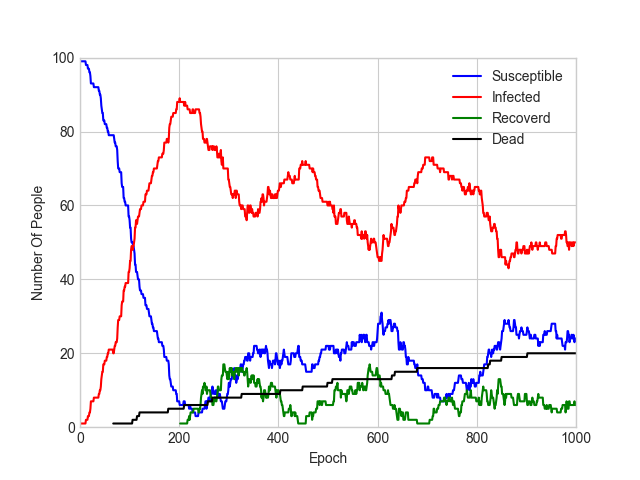

In [16]:

susceptible_table = simulation[simulation['Status'].str.contains('Susceptible')]
susceptible_plot = susceptible_table.groupby('Epoch')['Status'].count()

infected_table = simulation[simulation['Status'].str.contains('Infected')]
infected_plot = infected_table.groupby('Epoch')['Status'].count()

recovered_table = simulation[simulation['Status'].str.contains('Recovered')]
recovered_plot = recovered_table.groupby('Epoch')['Status'].count()

dead_table = simulation[simulation['Status'].str.contains('Dead')]
dead_plot = dead_table.groupby('Epoch')['Status'].count()

plt.figure(3)

ax = plt.axes()

ax.plot(susceptible_plot, 'b', label='Susceptible')
ax.plot(infected_plot, 'r', label='Infected')
ax.plot(recovered_plot, 'g', label='Recoverd')
ax.plot(dead_plot, 'k', label='Dead')

leg = ax.legend()

ax.set(xlim=(0, sim_length), ylim=(0, num_people), 
      xlabel='Epoch', ylabel='Number Of People');
